In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

import MySQLdb

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7.0, 5.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

In [116]:
store = pandas.HDFStore("diffim_counts.h5",'r')

In [66]:
src = store['Sources']
src_coord = SkyCoord(ra=src['ra'], dec=src['dec'], unit=(u.deg, u.deg))
src['galactic_lat'] = src_coord.galactic.b.deg
src['galactic_lon'] = src_coord.galactic.l.deg

In [161]:
dia = store['diaSources']
del dia['ra']  # RA and Dec are broken in the dia source data for some reason
del dia['dec']

combined_table = pandas.merge(dia, src, how="left", on=["visitid", "ccdnum"],
                          suffixes=("_dia", "_src"))

grp = combined_table.groupby(['visitid'], as_index=False)
combined_visits = grp.agg({'counts_dia': np.sum,
                           'counts_src': np.sum,
                           'ra': np.mean,
                           'dec': np.mean,
                           'galactic_lat': np.mean,
                           'galactic_lon': np.mean,
                           'ccdnum': len}) # ccdnum becomes the number of ccds processed

templates = [197790, 197662, 197408, 197384, 197371]
combined_visits['is_template'] = [id in templates for id in combined_visits['visitid']]

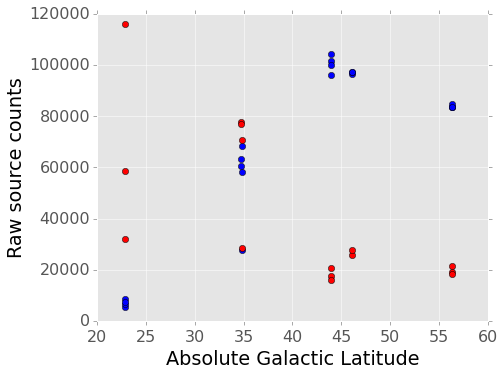

In [157]:
is_ok = combined_visits['is_template'] == False
plt.plot(np.abs(combined_visits['galactic_lat']), combined_visits['counts_src'], 'bo')
plt.plot(np.abs(combined_visits['galactic_lat'][is_ok]), combined_visits['counts_dia'][is_ok], 'ro')
plt.xlabel("Absolute Galactic Latitude")
plt.ylabel("Raw counts")

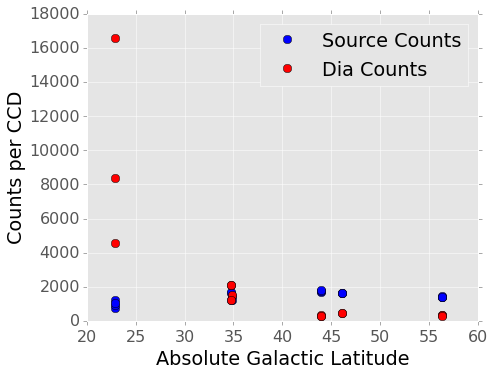

In [201]:
fig = plt.figure()
is_ok = combined_visits['is_template'] == False

src_ratio = combined_visits['counts_src']/combined_visits['ccdnum'].astype(float)
dia_ratio = combined_visits['counts_dia']/combined_visits['ccdnum'].astype(float)
plt.plot(np.abs(combined_visits['galactic_lat']), src_ratio, 'bo',
         label="Source Counts", ms=8)
plt.plot(np.abs(combined_visits['galactic_lat'][is_ok]), dia_ratio[is_ok], 'ro',
         label="Dia Counts", ms=8)

plt.xlabel("Absolute Galactic Latitude")
plt.ylabel("Counts per CCD")
plt.legend(loc=0, numpoints=1)
#plt.ylim(0,4000)

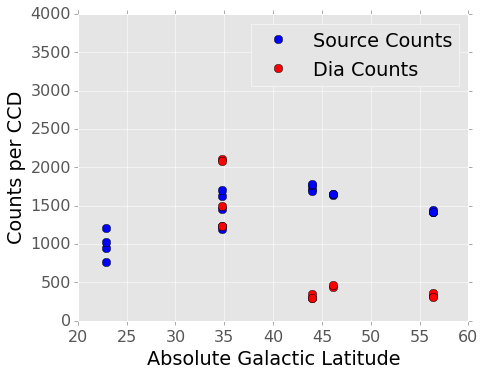

In [203]:
fig.axes[0].set_ylim(0,4000)
fig

MySQL below here
---

In [145]:
sq_deg_per_ccd = 2000*4090*(0.263)**2/(3600.0)**2
print sq_deg_per_ccd

0.0436575941358


In [335]:
db = MySQLdb.connect(db="diffim", read_default_file="~/.my.cnf")
cursor = db.cursor()

In [327]:
cursor.execute("SELECT visitid, templateVisitId, AVG(coord_ra), AVG(coord_dec), "
               "COUNT(DISTINCT ccdnum), count(visitid), sum(classification_dipole) "
               "FROM diasource GROUP BY visitid;")
rows = cursor.fetchall()
#rows

counts_table = Table(rows=rows, names=("visit", "templateVisit", "field_ra", "field_dec",
                                       "ccd_count", "source_count", "dipole_count"))
src_coord = SkyCoord(ra=counts_table['field_ra'],
                     dec=counts_table['field_dec'],
                     unit=(u.deg, u.deg))
counts_table['galactic_lat'] = src_coord.galactic.b.deg
counts_table['galactic_lon'] = src_coord.galactic.l.deg
counts_table

visit,templateVisit,field_ra,field_dec,ccd_count,source_count,dipole_count,galactic_lat,galactic_lon
int64,int64,float64,float64,int64,int64,float64,float64,float64
197367,197371,189.940122947,-6.4218900148,59,19193,2955.0,56.3310521085,297.694084593
197375,197371,190.16253723,-6.43484745218,59,21344,2705.0,56.3355184124,298.093374265
197379,197371,189.900300433,-6.40352896252,59,18118,2599.0,56.3460925996,297.620204211
197388,197384,196.991694053,-16.6366126458,59,25813,3449.0,46.0518207093,308.641321478
197392,197384,197.137494779,-16.5777656452,59,27580,3401.0,46.0972629112,308.849813182
197400,197408,199.984918671,-18.438945989,59,17666,3644.0,43.9119197404,312.332955268
197404,197408,199.977674667,-18.4391145473,59,20573,3794.0,43.9128057352,312.32349272
197412,197408,199.936094612,-18.475675074,54,16090,3519.0,43.8826923537,312.261655572
197802,197790,81.5513708058,-8.71962794566,7,115968,1615.0,-22.8795755442,211.136872434


(0, 40000.0)

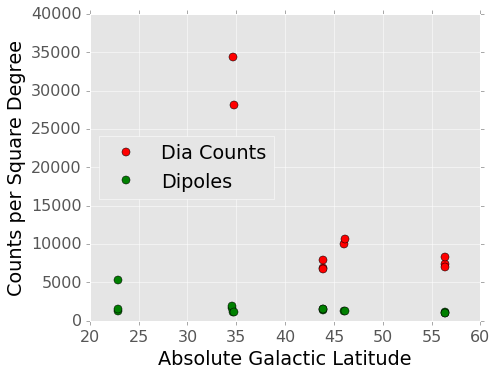

In [156]:
plt.plot(np.abs(counts_table['galactic_lat']),
         counts_table["source_count"]/counts_table["ccd_count"]/sq_deg_per_ccd, 'ro',
         label="Dia Counts", ms=8)
plt.plot(np.abs(counts_table['galactic_lat']),
         counts_table["dipole_count"]/counts_table["ccd_count"]/sq_deg_per_ccd, 'go',
         label="Dipoles", ms=8)
plt.xlabel("Absolute Galactic Latitude")
plt.ylabel("Counts per Square Degree")
plt.legend(loc=0, numpoints=1)
plt.ylim(0,40e3)

(0, 15000.0)

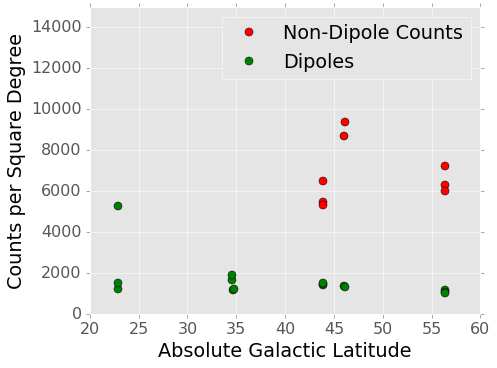

In [197]:
plt.plot(np.abs(counts_table['galactic_lat']),
         (counts_table["source_count"] - counts_table["dipole_count"])/counts_table["ccd_count"]/sq_deg_per_ccd, 'ro',
         label="Non-Dipole Counts", ms=8)
plt.plot(np.abs(counts_table['galactic_lat']),
         counts_table["dipole_count"]/counts_table["ccd_count"]/sq_deg_per_ccd, 'go',
         label="Dipoles", ms=8)
plt.xlabel("Absolute Galactic Latitude")
plt.ylabel("Counts per Square Degree")
plt.legend(loc=0, numpoints=1)
plt.ylim(0,15e3)

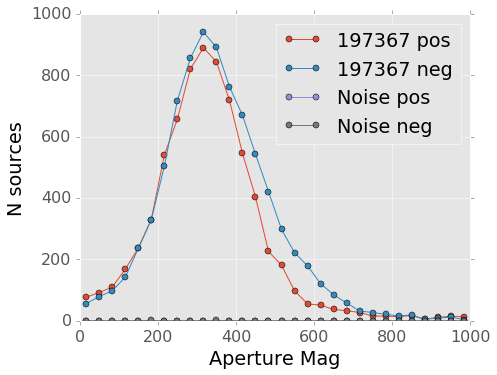

In [210]:
sel, = np.where(counts_table['galactic_lat'] > 55)
high_lat_visits = np.array(counts_table['visit'][sel])
high_lat_visits

for visit in high_lat_visits:
    cursor.execute("SELECT base_CircularApertureFlux_4_5_flux FROM diasource "
                   "WHERE visitid=%s AND classification_dipole = 0 "
                   "AND base_CircularApertureFlux_4_5_flux IS NOT NULL;", ( visit,))
    result_table = Table(rows=cursor.fetchall(), names=("ap_flux",), dtype=('i4',))
    #ap_flux = np.array(rows)
    sel_pos, = where(result_table["ap_flux"] > 0)
    H_pos, bins = np.histogram(np.abs(result_table["ap_flux"][sel_pos]), bins=30, range=(0,1e3))
    sel_neg, = where(result_table["ap_flux"] < 0)
    H_neg, _ = np.histogram(np.abs(result_table["ap_flux"][sel_neg]), bins=bins)

    bin_centers = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bin_centers, H_pos, 'o-', label="{:d} pos".format(visit))
    plt.plot(bin_centers, H_neg, 'o-', label="{:d} neg".format(visit))
    break
    
#
# Noise
visit = 197367
cursor.execute("SELECT base_PsfFlux_flux FROM diasource_noise "
                   "WHERE classification_dipole = 0 "
                   "AND base_PsfFlux_flux IS NOT NULL;")
result_table = Table(rows=cursor.fetchall(), names=("ap_flux",), dtype=('i4',))
#ap_flux = np.array(rows)
sel_pos, = where(result_table["ap_flux"] > 0)
H_pos, bins = np.histogram(np.abs(result_table["ap_flux"][sel_pos]), bins=30, range=(0,1e3))
sel_neg, = where(result_table["ap_flux"] < 0)
H_neg, _ = np.histogram(np.abs(result_table["ap_flux"][sel_neg]), bins=bins)

bin_centers = 0.5*(bins[1:] + bins[:-1])
plt.plot(bin_centers, H_pos, 'o-', label="Noise pos".format(visit))
plt.plot(bin_centers, H_neg, 'o-', label="Noise neg".format(visit))

plt.legend(loc=0)
plt.xlabel("Aperture Mag")
plt.ylabel("N sources")

In [208]:
print 2*peaks_in_image(4.0, psf_size, x_size, y_size)
print 2*peaks_in_image(5.05, psf_size, x_size, y_size)

13235.1989519
144.384377128


When running noise-replaced images, I got about 350 diasources over 59 chips, or 135 per square degree.

Total Positive sources:  7085
Positive sources per sq deg:  2748.66268688


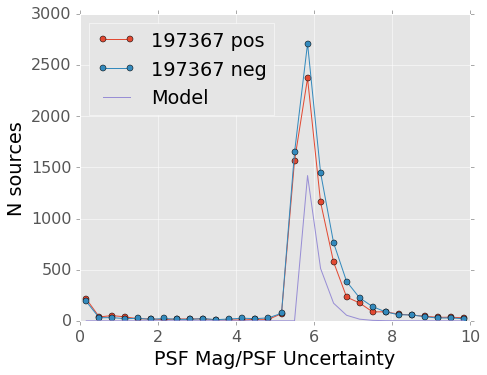

In [337]:
for visit in high_lat_visits:
    cursor.execute("SELECT base_PsfFlux_flux, base_PsfFlux_fluxSigma FROM diasource "
                   "WHERE visitid=%s AND classification_dipole = 0 "
                   "AND base_PsfFlux_flux IS NOT NULL;", (visit,))
    result_table = Table(rows=cursor.fetchall(), names=("psf_flux","psf_flux_sigma"),
                         dtype=('f8','f8'))
    #ap_flux = np.array(rows)
    psf_over_sigma = np.abs(result_table["psf_flux"])/result_table["psf_flux_sigma"]
    sel_pos, = where(result_table["psf_flux"] > 0)
    H_pos, bins = np.histogram(psf_over_sigma[sel_pos],
                               bins=30, range=(0,10))
    sel_neg, = where(result_table["psf_flux"] < 0)
    H_neg, _ = np.histogram(psf_over_sigma[sel_neg], bins=bins)

    bin_centers = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bin_centers, H_pos, 'o-', label="{:d} pos".format(visit))
    plt.plot(bin_centers, H_neg, 'o-', label="{:d} neg".format(visit))
    print "Total Positive sources: ", sum(H_pos)
    print "Positive sources per sq deg: ", sum(H_pos)/59/sq_deg_per_ccd

    break
    
#
# Noise Model
#
def peaks_above_sigma(nu):
    coeff = 1/(2**(5/2.0)*np.pi**(3/2.0))
    out = coeff*nu*np.exp(-nu**2/2.0)
    return out

def peaks_in_image(nu_threshold, psf_sigma, width, height):
    return peaks_above_sigma(nu_threshold)*width*height/psf_sigma**2

nchips = 60
x_size = 4096
y_size = 2048*nchips
psf_size = 1.8

threshold_sigma_bins = linspace(0,10,31)
sigma_scaling = 1/1.15**2
differential_counts = (peaks_in_image(threshold_sigma_bins[:-1]*sigma_scaling,
                                      psf_size, x_size, y_size) -
                       peaks_in_image(threshold_sigma_bins[1:]*sigma_scaling,
                                      psf_size, x_size, y_size))
plt.plot(0.5*(threshold_sigma_bins[:-1] + threshold_sigma_bins[1:]),
         differential_counts*(threshold_sigma_bins[:-1] > 5.5), '-', label="Model")

plt.legend(loc=0)
plt.xlabel("PSF Mag/PSF Uncertainty")
plt.ylabel("N sources")

Image Noise Properties
====

This uses the output from `measure_phot_errs.py`, which crossmatches two exposures and computes the measured difference in flux between the two images for each source, and compares that with the reported uncertainity on the flux measurement.

Visits 197367, 197371
----

This was one of the images with reasonable numbers of Dia sources.

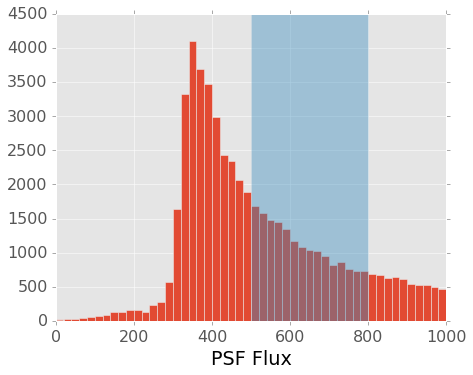

In [319]:
plt.hist(err_table['source_flux'], range=(0,1000), bins=50)
plt.fill_betweenx([0,4500],500,800, alpha=0.4, zorder=2)
plt.xlabel("PSF Flux")

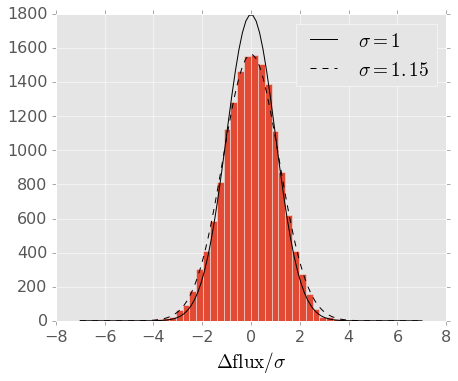

In [329]:
store = pandas.HDFStore("source_errs.h5")
err_table = store["source_errs"]
normed_err_vals = np.array(err_table["source_err"]/err_table["source_errnorm"])

# There are some entries with crazy high errnorm values (>1e6), need to exclude.
sel, = np.where((err_table["source_flux"] > 500) & (err_table["source_flux"] < 800) &
                (err_table["source_errnorm"] < 1e4))
H,bins,_ = plt.hist(normed_err_vals[sel] - np.median(normed_err_vals[sel]),
                    range=(-7,7), bins=50)

x = linspace(-7,7,100)
plt.plot(x, (bins[1] - bins[0])*len(sel)/np.sqrt(2*pi)*exp(-x**2/2.0),'k-',
        label="$\sigma=1$")
extra_sigma = 1.15
plt.plot(x, (bins[1] - bins[0])*len(sel)/np.sqrt(2*pi)/extra_sigma * \
             exp(-x**2/(2.0*extra_sigma**2)),'k--',
         label="$\sigma={:.2f}$".format(extra_sigma))
plt.xlabel(r"$\Delta \rm{flux}/\sigma$")
plt.legend(loc=0)

Visits 197662, 198668
-----

These visits were at low latitude and had very high numbers of Dia sources

plt.hist(err_table_b35['source_flux'], range=(0,2000), bins=50)
plt.fill_betweenx([0,2000],1000,1500, alpha=0.4, zorder=2)
plt.xlabel("PSF Flux")

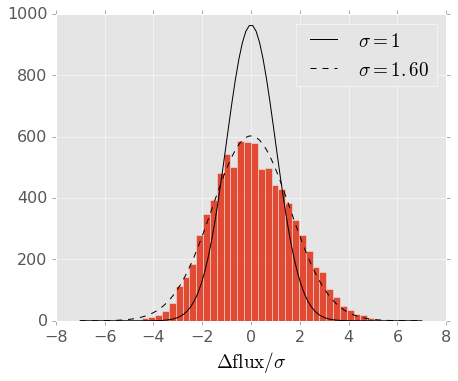

In [328]:
store_b35 = pandas.HDFStore("source_errs_b35.h5")
err_table_b35 = store_b35["source_errs"]
normed_err_vals_b35 = np.array(err_table_b35["source_err"]/err_table_b35["source_errnorm"])

# There are some entries with crazy high errnorm values (>1e6), need to exclude.
sel, = np.where((err_table_b35["source_flux"] > 1000) &
                (err_table_b35["source_flux"] < 1500) &
                (err_table_b35["source_errnorm"] < 1e4))
H,bins,_ = plt.hist(normed_err_vals_b35[sel] - np.median(normed_err_vals_b35[sel]),
                    range=(-7,7), bins=50)

x = linspace(-7,7,100)
plt.plot(x, (bins[1] - bins[0])*len(sel)/np.sqrt(2*pi)*exp(-x**2/2.0),'k-',
         label="$\sigma=1$")
extra_sigma = 1.6
plt.plot(x, (bins[1] - bins[0])*len(sel)/np.sqrt(2*pi)/extra_sigma * \
             exp(-x**2/(2.0*extra_sigma**2)),'k--',
         label="$\sigma={:.2f}$".format(extra_sigma))
plt.xlabel(r"$\Delta \rm{flux}/\sigma$")
plt.legend(loc=0)